In [1]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 80% !important; }</style>"))
import ssl 
ssl._create_default_https_context = ssl._create_unverified_context
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
seed = 42
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
import numpy as np
np.random.seed(seed)
import logging
import random
random.seed(seed)
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)
#from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import cv2
from statsmodels.tsa.stattools import acf
#%matplotlib widget

2.15.0


In [2]:
def rolling_window(array, window_shape, stride=1):
    array = np.array(array)
    shape = (array.shape[0] - window_shape + 1, window_shape)
    strides = (array.strides[0],) + array.strides
    rolled = np.lib.stride_tricks.as_strided(array, shape=shape, strides=strides)
    return rolled[np.arange(0, shape[0], stride)]

In [3]:
datas = np.load('training_dataset/training_data.npy', allow_pickle=True)
indexes = np.load('training_dataset/valid_periods.npy', allow_pickle=True)
labels = np.load('training_dataset/categories.npy', allow_pickle=True)

In [4]:
categories = ['A', 'B', 'C', 'D', 'E', 'F']
window_sizes = {'A':200, 'B':200, 'C':200, 'D':200, 'E':200, 'F':200}
output_window_sizes = {'A':18, 'B':18, 'C':18, 'D':18, 'E':18, 'F':18}
encodings = {'A':np.array([1,0,0,0,0,0]).reshape(1,-1),
            'B':np.array([0,1,0,0,0,0]).reshape(1,-1),
            'C':np.array([0,0,1,0,0,0]).reshape(1,-1),
            'D':np.array([0,0,0,1,0,0]).reshape(1,-1),
            'E':np.array([0,0,0,0,1,0]).reshape(1,-1),
            'F':np.array([0,0,0,0,0,1]).reshape(1,-1),
           }



X = {}
y = {}

X_train = {}
y_train = {}

X_validation = {}
y_validation = {}

X_test = {}
y_test = {}

stride = 1

In [5]:
for i,category in enumerate(categories):
    label_filter = labels == category
    batch_data = datas[label_filter]
    batch_index = indexes[label_filter]
    N = batch_data.shape[0]
    window = window_sizes[category]
    output_window_size = output_window_sizes[category]

    #--------------------------------------------------------
    X[category] = []
    y[category] = []

    X_test[category] = []
    y_test[category] = []

    X_validation[category] = []
    y_validation[category] = []

    X_train[category] = []
    y_train[category] = []
    #--------------------------------------------------------

    encode = encodings[category]


    for n in range(N):
        start = batch_index[n,0]
        end = batch_index[n,1]

        if (end - start) < (window + output_window_size + 2):
          continue

        x_n = pd.Series(batch_data[n,start:end])
        y_n = rolling_window(x_n[window:],output_window_size,stride)


        x_n = rolling_window(x_n,window,stride)[:y_n.shape[0]]



        min = x_n.min(1).reshape(-1,1)
        max = x_n.max(1).reshape(-1,1)
        



        x_n = (x_n - min)/(max - min)
        y_n = (y_n - min)/(max - min)

        c1 = ((y_n < -1.75).sum(1) == 0)
        c2 = ((y_n > 1.75).sum(1) == 0)
        c = c1&c2
        
        x_n = x_n[c]
        y_n = y_n[c]
        
        
        x_n = np.concatenate([x_n,np.repeat(encode,x_n.shape[0], axis=0)],axis = 1)

        nan_mask = ~np.isnan(x_n).any(axis=1)
        x_n = x_n[nan_mask]
        y_n = y_n[nan_mask]
        #--------------------------------------------------------
        X[category].append(x_n)
        y[category].append(y_n)



    #--------------------------------------------------------
    X_train[category], X_test[category], y_train[category], y_test[category] = train_test_split(np.concatenate(X[category]), np.concatenate(y[category]), test_size=0.3, random_state=42)
    X_validation[category], X_test[category], y_validation[category], y_test[category] = train_test_split(X_test[category], y_test[category], test_size=0.3, random_state=42)
    del X[category],y[category]
    #--------------------------------------------------------
    print('---------------------------------------------------------------')
    print('{} train size = '.format(category),X_train[category].shape,y_train[category].shape)
    print('{} validation size = '.format(category),X_validation[category].shape,y_validation[category].shape)
    print('{} test size = '.format(category),X_test[category].shape,y_test[category].shape)



---------------------------------------------------------------
A train size =  (308809, 206) (308809, 18)
A validation size =  (92642, 206) (92642, 18)
A test size =  (39705, 206) (39705, 18)
---------------------------------------------------------------
B train size =  (191666, 206) (191666, 18)
B validation size =  (57500, 206) (57500, 18)
B test size =  (24643, 206) (24643, 18)
---------------------------------------------------------------
C train size =  (316988, 206) (316988, 18)
C validation size =  (95097, 206) (95097, 18)
C test size =  (40756, 206) (40756, 18)
---------------------------------------------------------------
D train size =  (412706, 206) (412706, 18)
D validation size =  (123812, 206) (123812, 18)
D test size =  (53063, 206) (53063, 18)
---------------------------------------------------------------
E train size =  (252046, 206) (252046, 18)
E validation size =  (75614, 206) (75614, 18)
E test size =  (32406, 206) (32406, 18)
---------------------------------

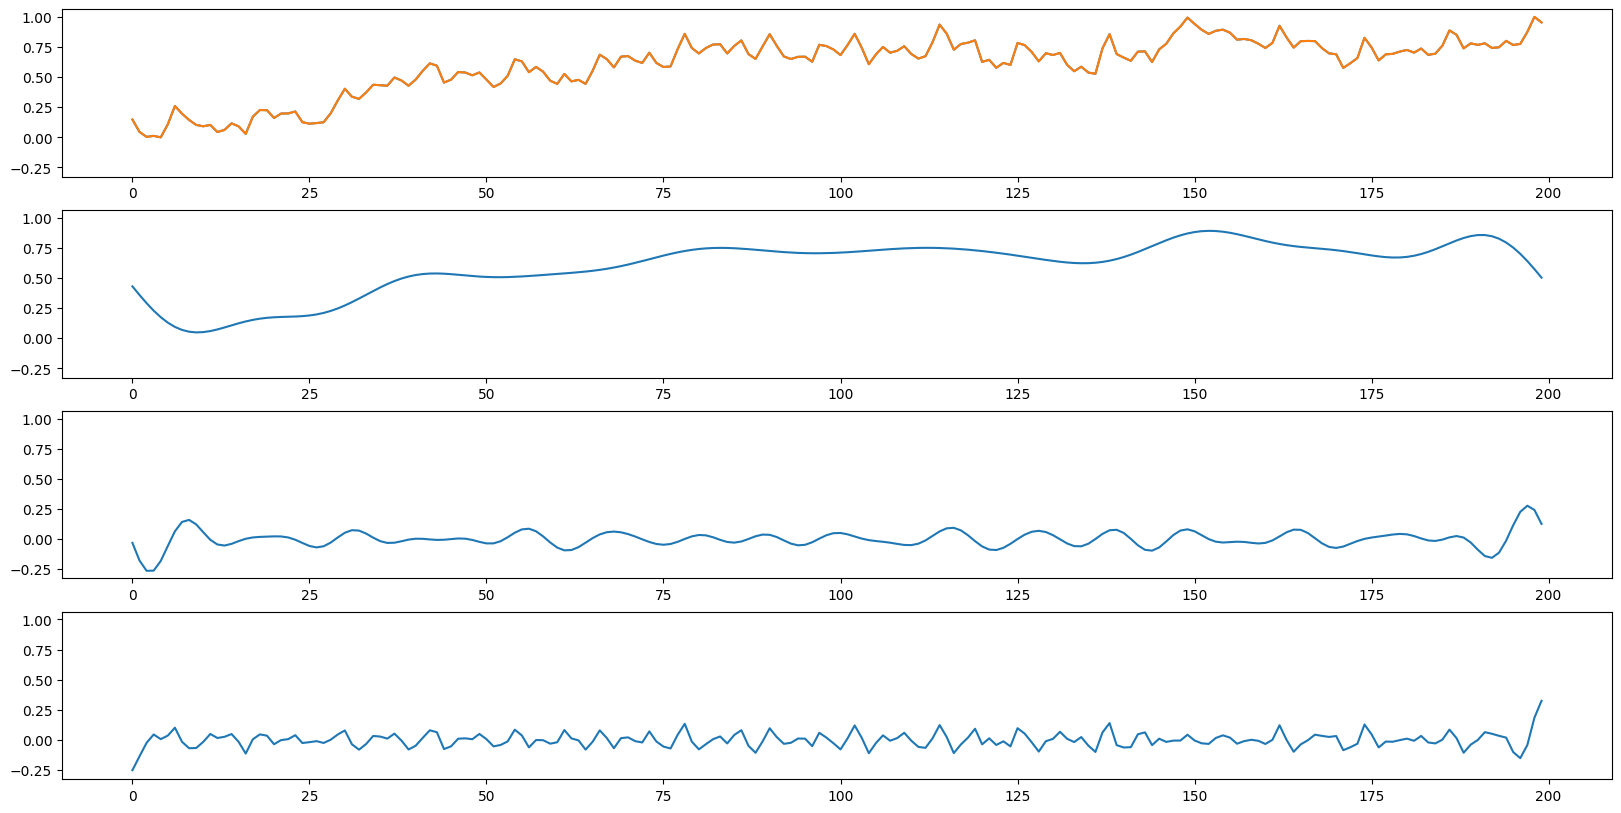

In [6]:
i = np.random.randint(X_train['A'].shape[0])
x = X_train['A'][i,:200]
x_fft = np.fft.fft(x)


x_1 = x_fft.copy()
x_2 = x_fft.copy()
x_3 = x_fft.copy()
x_4 = x_fft.copy()


x_1[10:100] = 0
x_1[100:190] = 0

x_2[0:10] = 0
x_2[190:200] = 0

x_2[25:100] = 0
x_2[100:175] = 0

x_3[0:25] = 0
x_3[175:200] = 0



fig,axs = plt.subplots(4,1,figsize = [20,10],sharey =True)

axs[0].plot(x)
axs[0].plot(np.fft.ifft(x_1) + np.fft.ifft(x_2) + np.fft.ifft(x_3))

axs[1].plot(np.fft.ifft(x_1))
axs[2].plot(np.fft.ifft(x_2))
axs[3].plot(np.fft.ifft(x_3))


In [8]:
np.save('windowed_training_data/test_X.npy', X_test)
np.save('windowed_training_data/test_y.npy', y_test)

np.save('windowed_training_data/validation_X.npy', X_validation)
np.save('windowed_training_data/validation_y.npy', y_validation)

np.save('windowed_training_data/train_X.npy', X_train)
np.save('windowed_training_data/train_y.npy', y_train)

: 